In [1]:
!nvidia-smi -L

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-b52722a2-32a9-f2ad-5a39-bb2d36cd5841)


In [2]:
#!unzip ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip

Archive:  ./drive/MyDrive/single-person-pose-estimation/dataset/tfrecords.zip
   creating: dataset/tfrecords/
   creating: dataset/tfrecords/valid/
  inflating: dataset/tfrecords/valid/file_valid_01-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_03-208.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_02-2048.tfrec  
  inflating: dataset/tfrecords/valid/file_valid_00-2048.tfrec  
   creating: dataset/tfrecords/train/
  inflating: dataset/tfrecords/train/file_train_00-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_26-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_12-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_47-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_05-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_35-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_13-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train_69-2048.tfrec  
  inflating: dataset/tfrecords/train/file_train

In [1]:
import sys
import time
from datetime import datetime, timedelta
sys.path.append('/content/drive/MyDrive/single-person-pose-estimation')
from configs import default_config as cfg



---



---
Dataset


In [2]:
from dataset_builder import DatasetBuilder

In [3]:
ds_builder = DatasetBuilder(cfg)

Train dataset with 149813 examples.
Valid dataset with 6352 examples.




---



---
Model


In [4]:
from model.hourglass import HourGlassNet

In [5]:
HG = HourGlassNet(cfg.NUM_KEYPOINTS, cfg.HG_NUM_STACKS, cfg.HG_NUM_FILTERS, 
              (cfg.IMAGE_HEIGHT, cfg.IMAGE_WIDTH, 3), 
              (cfg.LABEL_HEIGHT, cfg.LABEL_WIDTH, cfg.NUM_KEYPOINTS))
model = HG.create_hg_model()

Created HourGlassmodel:
    1. 4 stacks.
    2. 12080324 parameters. Call object.get_summary() for more detail.
    




---



---
TRAINER


In [6]:
from trainer import Trainer



---
Initial train (run once at the start)


In [12]:
trainer = Trainer(model, ds_builder, epochs = 20, learning_rate = 0.01, config = cfg)

In [ ]:
trainer.train()

Start traing with:
    1. Current date 22-03-2022.
    2. Number of epochs 20.
    3. Learning rate 0.01.
    4. Batch size 16.
    

Learning rate for epoch 1 is 0.009999999776482582
Epoch 1/20
9363/9363 [==============================] - ETA: 0s - loss: 0.0037 - heatmap1_loss: 9.3862e-04 - heatmap2_loss: 9.1515e-04 - heatmap3_loss: 9.1282e-04 - heatmap4_loss: 9.0787e-04
Epoch 1: val_loss improved from inf to 0.00328, saving model to temp/checkpoints/22-03-2022-E20.cpkt
9363/9363 [==============================] - 2736s 290ms/step - loss: 0.0037 - heatmap1_loss: 9.3862e-04 - heatmap2_loss: 9.1515e-04 - heatmap3_loss: 9.1282e-04 - heatmap4_loss: 9.0787e-04 - val_loss: 0.0033 - val_heatmap1_loss: 8.5112e-04 - val_heatmap2_loss: 8.1913e-04 - val_heatmap3_loss: 8.0720e-04 - val_heatmap4_loss: 8.0431e-04

Learning rate for epoch 2 is 0.009999999776482582
Epoch 2/20
9363/9363 [==============================] - ETA: 0s - loss: 0.0031 - heatmap1_loss: 8.0393e-04 - heatmap2_loss: 7.6817e-04 - 

In [ ]:
# to drive
!cp -r ./temp ./drive/MyDrive/single-person-pose-estimation



---
Resume train 1, half the learning rate 0.001/2 = 0.0005


In [ ]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [ ]:
trainer = Trainer(model, ds_builder, epochs = 20, learning_rate = 5e-4, config = cfg)

In [ ]:
trainer.resume_training()

Loading best weights from temp/checkpoints
Optimizer configs: {'name': 'Adam', 'learning_rate': 0.0005, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
learning_rate:0.0005000000237487257
Start traing with:
    1. Current date 24-03-2022.
    2. Resume training for 20, from epoch 20 to epoch 40.
    3. Learning rate 0.0005000000237487257.
    4. batch size 16.
    

Learning rate for epoch 21 is 0.0005000000237487257
Epoch 21/40
9363/9363 [==============================] - ETA: 0s - loss: 0.0026 - heatmap1_loss: 7.0896e-04 - heatmap2_loss: 6.6111e-04 - heatmap3_loss: 6.4187e-04 - heatmap4_loss: 6.3759e-04
Epoch 21: val_loss improved from inf to 0.00263, saving model to temp/checkpoints/24-03-2022-E40.cpkt
9363/9363 [==============================] - 2728s 289ms/step - loss: 0.0026 - heatmap1_loss: 7.0896e-04 - heatmap2_loss: 6.6111e-04 - heatmap3_loss: 6.4187e-04 - heatmap4_loss: 6.3759e-04 - val_loss: 0.0026 - val_heatmap1_loss: 7.0877e-04 - val_heatm

In [ ]:
# to drive
!cp -r ./temp ./drive/MyDrive/single-person-pose-estimation



---

Resume train 5, half the learning rate 5e-4/2 = 2.5-4

In [ ]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [7]:
trainer = Trainer(model, ds_builder, epochs = 20, learning_rate = 2.5e-4, config = cfg)

In [8]:
trainer.resume_training()

Loading best weights from temp/checkpoints
Loaded: 24-03-2022-E40.cpkt.index
Optimizer configs: {'name': 'Adam', 'learning_rate': 0.00025, 'decay': 0.0, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
learning_rate:0.0002500000118743628
Start traing with:
    1. Current date 24-03-2022.
    2. Resume training for 20 epochs, from epoch 40 to epoch 60.
    3. Learning rate 0.0002500000118743628.
    4. batch size 16.
    

Learning rate for epoch 41 is 0.0002500000118743628
Epoch 41/60
9363/9363 [==============================] - ETA: 0s - loss: 0.0026 - heatmap1_loss: 6.9840e-04 - heatmap2_loss: 6.4268e-04 - heatmap3_loss: 6.1486e-04 - heatmap4_loss: 6.0872e-04
Epoch 41: val_loss improved from inf to 0.00254, saving model to temp/checkpoints/24-03-2022-E60.cpkt
9363/9363 [==============================] - 2736s 290ms/step - loss: 0.0026 - heatmap1_loss: 6.9840e-04 - heatmap2_loss: 6.4268e-04 - heatmap3_loss: 6.1486e-04 - heatmap4_loss: 6.0872e-04 - val_loss: 0.0025 -

In [9]:
# to drive
!cp -r ./temp ./drive/MyDrive/single-person-pose-estimation




---


---


Test prediction

Should reset runtime


In [14]:
# from drive
!cp -r ./drive/MyDrive/single-person-pose-estimation/temp ./

In [9]:
import matplotlib.pyplot as plt
import tensorflow as tf

In [15]:
loaded_model = trainer.get_best_weights_model()

Loading best weights from temp/checkpoints


In [16]:
ds = ds_builder.get_ds_prediction().take(5)

In [17]:
pred1, pred2, pred3, pred4 = loaded_model.predict(ds)

In [25]:
it = iter(ds)

In [33]:
images_batch, heatmaps_batch = next(it)

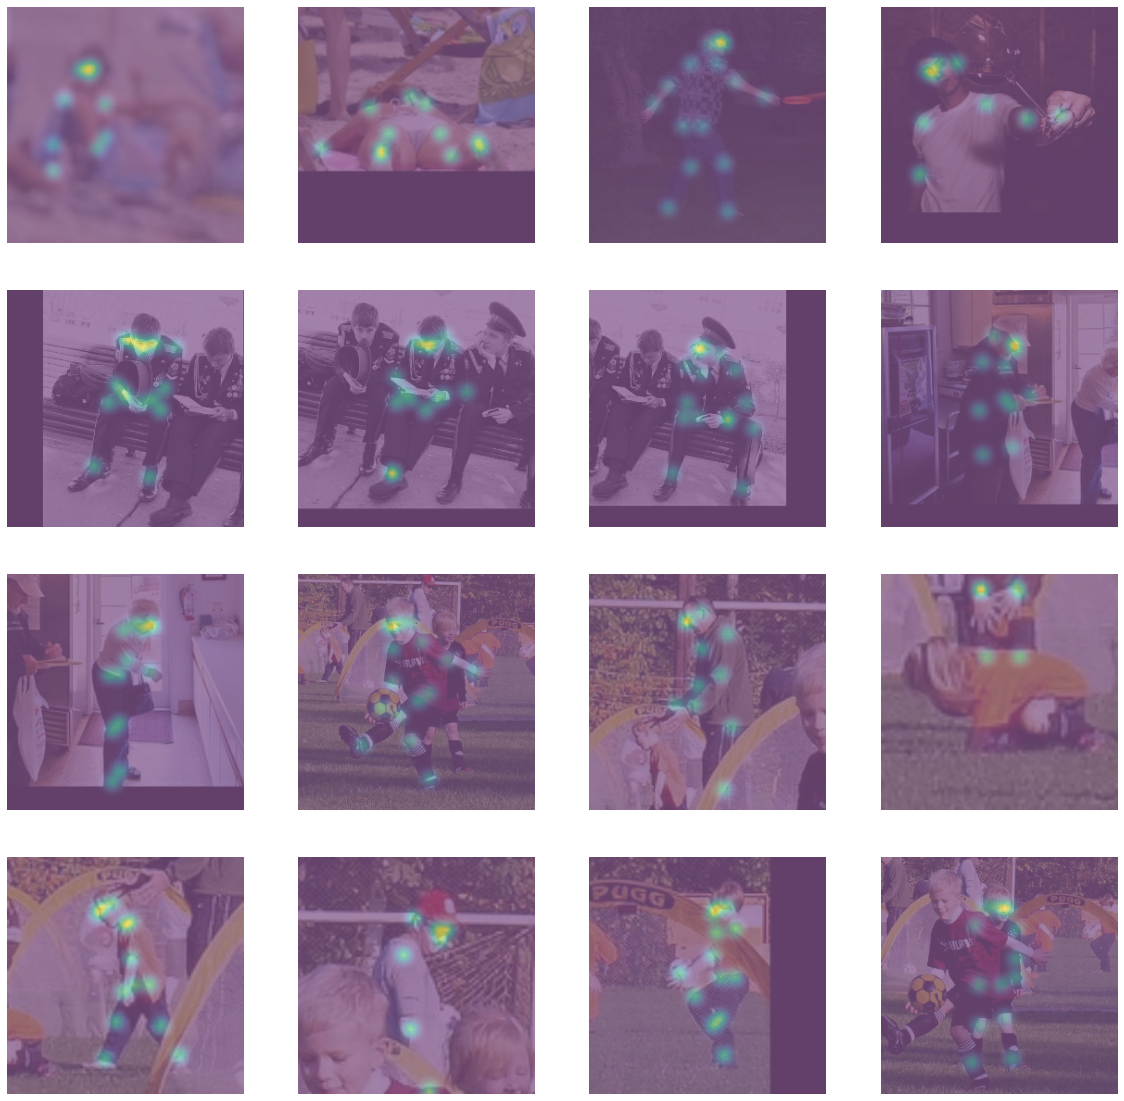

In [34]:
#Truth ground
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(16/4, 16/4, i + 1)
    plt.imshow(images_batch[i], cmap = 'gray', alpha = 0.5)
    h = tf.image.resize(heatmaps_batch[i], (256, 256))
    plt.imshow(tf.reduce_sum(h, axis = -1), alpha = 0.5)
    plt.axis("off")

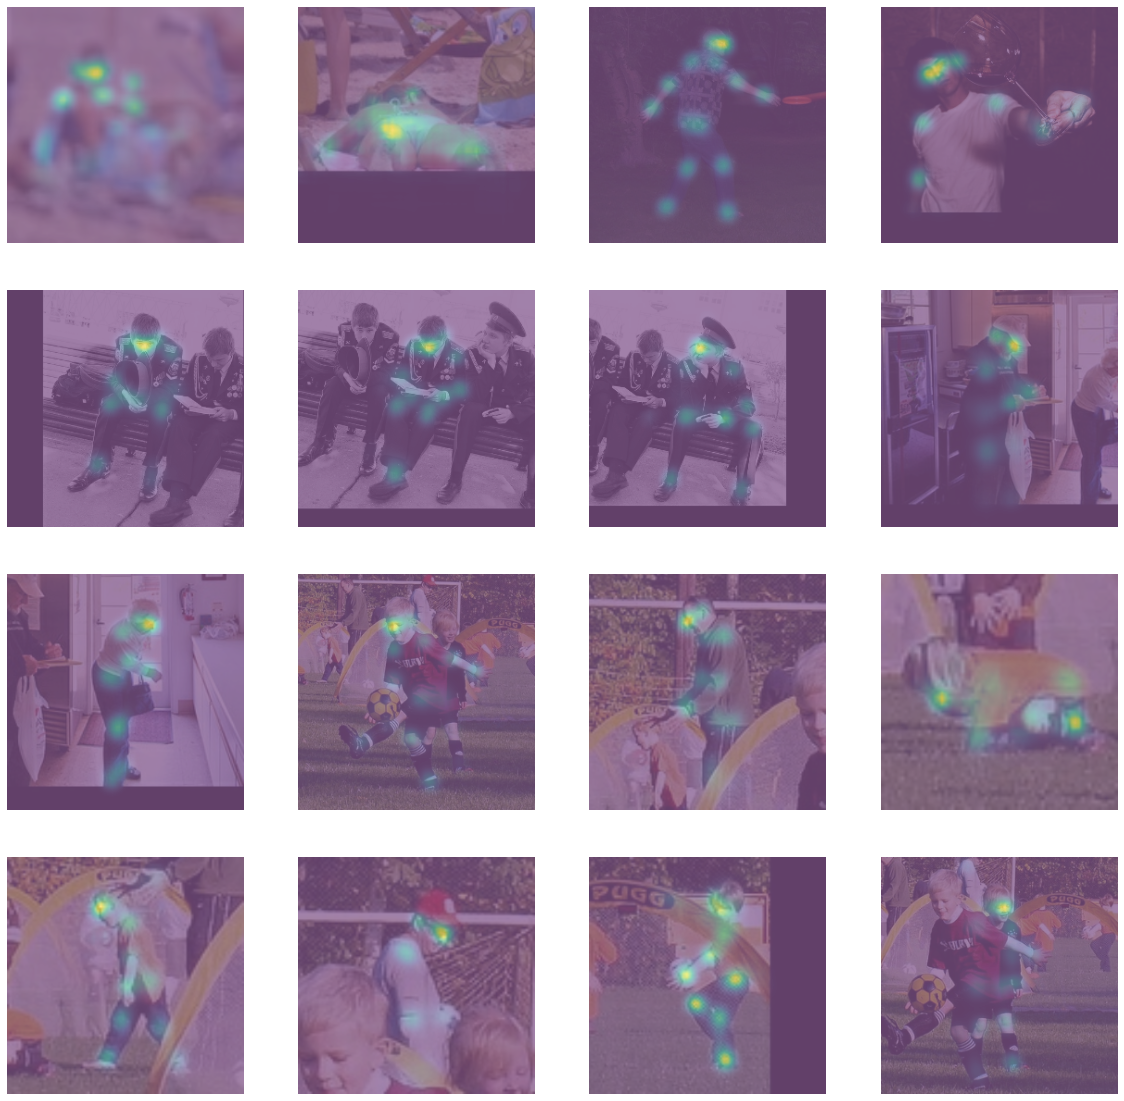

In [35]:
#RME loss
plt.figure(figsize=(20,20))
for i in range(16):
    ax = plt.subplot(16/4, 16/4, i + 1)
    plt.imshow(images_batch[i], cmap = 'gray', alpha = 0.5)
    p = tf.image.resize(pred4[48 + i], (256,256))
    plt.imshow(tf.reduce_sum(p, axis = -1), alpha = 0.5)
    plt.axis("off")